# Buy/Not buy action predicted using SVC from actual data and predicted value from LSTM

This notebook utilised two machine learning model to predict action for intraday trading
it first uses LSTM to predict next day "High-Low" and "Close-Open" value from previous 60 days data chich consist of "High", "Low", "Open", "Close", "Volume", "Adj Close"
then a SVC model is trained on actual "High-Low" and "Close-Open" value to predict best action for intraday trading, 1 for buy at today close and sell at next day close and 0 for no action
Finally it uses the prediction from LSTM and feed into the SVC model to predict an action for intraday day trading with 1 day lead time.


In [1]:


# import library for Support Vector Classification
from sklearn.svm import SVC

# import library for plot
import matplotlib.pyplot as plt

# import library for data handling
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math

# import library for pytorch
import torch
import torch.nn as nn

# import custom function
from stock_predict import SequenceDataset, ShallowRegressionLSTM, train, test, get_stock_data, split_train_test, predict, svc_train

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# predict df
predict_df = pd.DataFrame(columns = ["High", "Low", "Open", "Close"])

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the past stock price
df = get_stock_data(stock_name = 'TSLA', source = 'yahoo', past_year = 2)


In [3]:
# Create the independent variables
df['High-Low'] = df['High'] - df['Low']
df['Open-Close'] = df['Open'] - df['Close']

In [4]:
pred_list = ['High-Low', 'Open-Close']

In [7]:
def run(df,training_target):

    # Split data into train and test
    train_df, test_df, feature, target, train_size, test_size, target_mean, target_std = split_train_test(training_target = training_target, df = df, train_ratio = 0.8)

    # create dataset and data loader
    batch_size = 4
    seq_len = 60

    torch.manual_seed(seq_len*batch_size/2)

    train_dataset = SequenceDataset(train_df, target, feature, seq_len)
    test_dataset = SequenceDataset(test_df, target, feature, seq_len)
    train_looader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # get the first batch and its shape
    x, y = next(iter(train_looader))
    print("Features shape: ", x.shape)
    print("Target shape: ", y.shape)

    # create model, loss and optimizer
    learning_rate = 5e-5
    num_hidden = 16
    num_layers = 2
    epochs = 40

    model = ShallowRegressionLSTM(n_features = len(feature), n_hidden = num_hidden, n_layers = num_layers, device=device).to(device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train and test model
    print("Untrained test\n----------------")
    test(model, test_loader, loss, device)
    print("\nTraining\n----------------")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n")
        train(model, train_looader, loss, optimizer, device)
        test(model, test_loader, loss, device)

    train_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    prediction = f"{target}"
    train_df[prediction] = predict(train_eval, model, device)
    test_df[prediction] = predict(test_loader, model, device)

    df_out = pd.concat([train_df, test_df], axis=0)[[prediction]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * target_std + target_mean
    
    return df_out


In [8]:
df_pred = pd.DataFrame()
for training_target in pred_list:
    print(f"Training target: {training_target}")
    df_out = run(df,training_target)
    df_pred = pd.concat([df_pred, df_out], axis=1)

Training target: High-Low
Features shape:  torch.Size([4, 60, 7])
Target shape:  torch.Size([4])
Untrained test
----------------
Test loss: 0.8381

Training
----------------
Epoch 1

Train loss: 1.0163
Test loss: 0.8282
Epoch 2

Train loss: 0.9853
Test loss: 0.8169
Epoch 3

Train loss: 0.9608
Test loss: 0.8075
Epoch 4

Train loss: 1.0070
Test loss: 0.7962
Epoch 5

Train loss: 0.9147
Test loss: 0.7836
Epoch 6

Train loss: 0.8626
Test loss: 0.7721
Epoch 7

Train loss: 0.8354
Test loss: 0.7622
Epoch 8

Train loss: 0.8104
Test loss: 0.7506
Epoch 9

Train loss: 0.8037
Test loss: 0.7406
Epoch 10

Train loss: 0.7537
Test loss: 0.7312
Epoch 11

Train loss: 0.7319
Test loss: 0.7233
Epoch 12

Train loss: 0.7156
Test loss: 0.7187
Epoch 13

Train loss: 0.6943
Test loss: 0.7147
Epoch 14

Train loss: 0.6794
Test loss: 0.7127
Epoch 15

Train loss: 0.6677
Test loss: 0.7119
Epoch 16

Train loss: 0.6572
Test loss: 0.7131
Epoch 17

Train loss: 0.6525
Test loss: 0.7143
Epoch 18

Train loss: 0.6384
Test lo

In [9]:
df_pred = df_pred.shift(-1)

In [10]:
df_pred = df_pred[:-1]

In [11]:
df_pred

,High-Low_t+1,Open-Close_t+1
Date,,
2020-09-21,10.121504,0.470582
2020-09-22,10.349747,0.558093
2020-09-23,10.079388,0.505719
2020-09-24,9.430521,0.428611
2020-09-25,8.861040,0.232812
...,...,...
2022-09-09,14.841762,0.286465
2022-09-12,15.037528,0.240884
2022-09-13,15.173054,0.121542


In [12]:
df

,High,Low,Open,Close,Volume,Adj Close,High-Low,Open-Close
Date,,,,,,,,
2020-09-21,151.893326,135.690002,151.043335,149.796661,328430400.0,149.796661,16.203323,1.246674
2020-09-22,145.919998,139.199997,143.199997,141.410004,238742400.0,141.410004,6.720001,1.789993
2020-09-23,137.383331,125.293335,135.053329,126.786667,285222600.0,126.786667,12.089996,8.266663
2020-09-24,133.166672,117.099998,121.266670,129.263336,289683300.0,129.263336,16.066673,-7.996666
2020-09-25,136.243332,130.433334,131.156662,135.779999,201625500.0,135.779999,5.809998,-4.623337
...,...,...,...,...,...,...,...,...
2022-09-13,297.399994,290.399994,292.899994,292.130005,68229600.0,292.130005,7.000000,0.769989
2022-09-14,306.000000,291.640015,292.239990,302.609985,72628700.0,302.609985,14.359985,-10.369995
2022-09-15,309.119995,300.720001,301.829987,303.750000,64795500.0,303.750000,8.399994,-1.920013


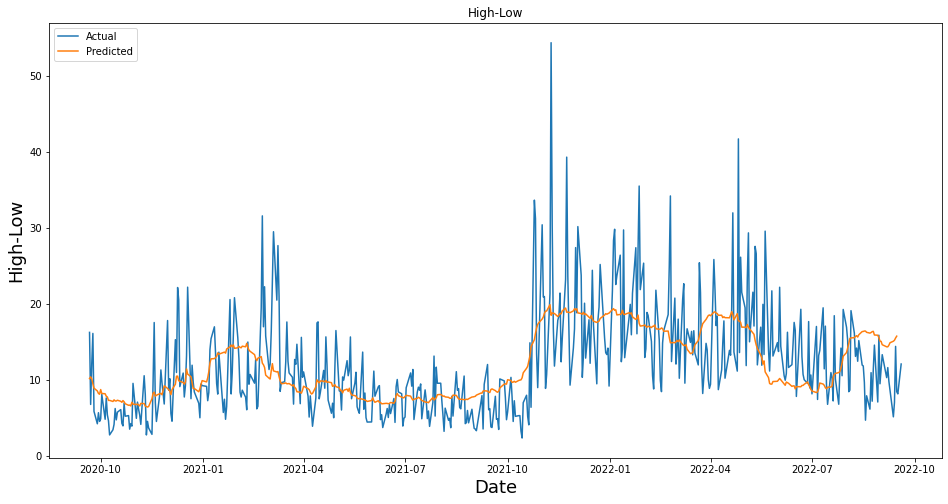

In [13]:
#plot High-Low
plt.figure(figsize=(16,8))
plt.title('High-Low')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High-Low', fontsize=18)
plt.plot(df['High-Low'], label = 'Actual')
plt.plot(df_pred['High-Low_t+1'], label = 'Predicted')
plt.legend(loc='upper left')
plt.show()

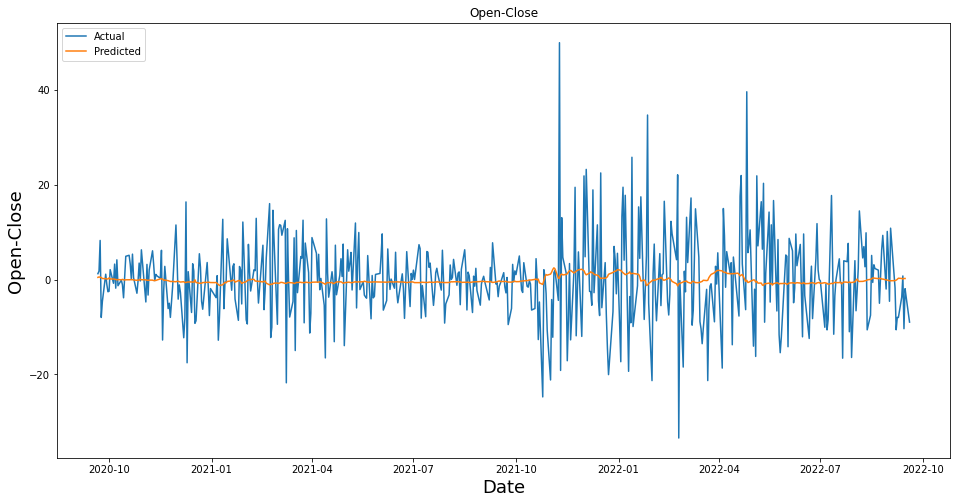

In [14]:
#plot Open-Close
plt.figure(figsize=(16,8))
plt.title('Open-Close')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open-Close', fontsize=18)
plt.plot(df['Open-Close'], label = 'Actual')
plt.plot(df_pred['Open-Close_t+1'], label = 'Predicted')
plt.legend(loc='upper left')
plt.show()

As shown on the graph above, the next work failed to capture the high frequency nature of the data but able to capture the trend (low frequency features). We will try to use the predicted values from the LSTM model as variable in SVC model that trained on actual data to see if the action from LSTM model peform better than the action from actual data.

In [15]:
# train action from actual data using svc
svc_model = svc_train(df)

In [21]:
df_pred.rename(columns = {'High-Low_t+1':'High-Low', 'Open-Close_t+1':'Open-Close'}, inplace = True)
df_pred['Close'] = df['Close']

In [24]:
df_pred['action'] = svc_model.predict(df_pred[['Open-Close','High-Low']])

In [25]:
df['action'] = svc_model.predict(df[['Open-Close','High-Low']])

<AxesSubplot:xlabel='Date'>

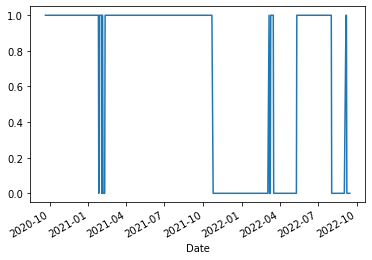

In [26]:
df_pred['action'].plot()

<AxesSubplot:xlabel='Date'>

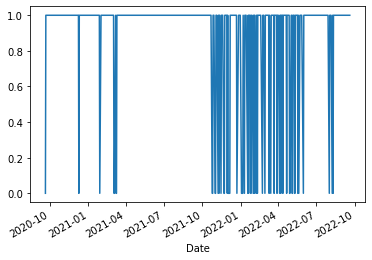

In [27]:
df['action'].plot()

In [28]:
# create a random actions for comparison
df_pred['random'] = np.random.randint(0,2, len(df_pred))

# Calculate the daily returns from the stock
df_pred['returns'] = df_pred['Close'].pct_change(1)
df['returns'] = df['Close'].pct_change(1)

# Calculate the strategy returns
df['strategy_returns'] = df['action'].shift(1) * df['returns']

# Calculate the LSTM based strategy returns
df_pred['LSTM_returns'] = df_pred['action'].shift(1) * df_pred['returns']

# Calculate the random strategy returns
df_pred['random_returns'] = df_pred['random'].shift(1) * df_pred['returns']


# Calculate the cumulative strategy returns
df['cum_strategy_returns'] = (df['strategy_returns']).cumsum()

# Calculate the cumulative LSTM based strategy returns
df_pred['cum_LSTM_returns'] = (df_pred['LSTM_returns']).cumsum()

# Calculate the cumulative random returns
df_pred['cum_random_returns'] = (df_pred['random_returns']).cumsum()

# Calculate the cumulative stock returns
df['cum_stock_returns'] = (df['returns']).cumsum()


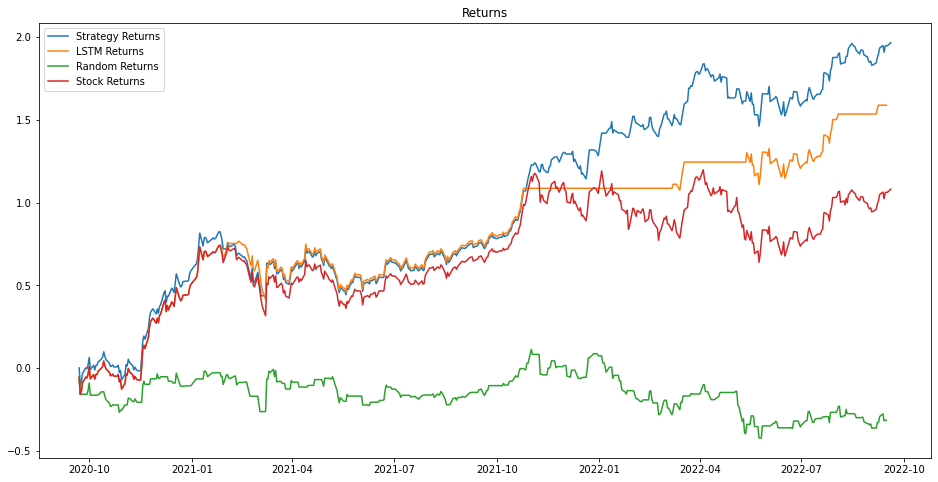

In [29]:
# plot the cumulative returns
plt.figure(figsize=(16,8))
plt.title('Returns')
plt.plot(df['cum_strategy_returns'], label='Strategy Returns')
plt.plot(df_pred['cum_LSTM_returns'], label='LSTM Returns')
plt.plot(df_pred['cum_random_returns'], label='Random Returns')
plt.plot(df['cum_stock_returns'], label='Stock Returns')
plt.legend()
plt.show()

The result above shows that the action from LSTM model is not better than the action from actual data. This is likely due to the LSTM model is not able to capture the high frequency nature. Therefore using it as a variable in SVC model is not able to improve the performance of the SVC model. However it still out perform random guess and buy and cumulate the stock.